## Setup

In [1]:
# Appling the GD algo to a bigger models and more interesting, we would be using secondnetwork.png
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [3]:
np.random.seed(0)

Explainng the secondnetwork.png network  
We have seen this network here.  
There are 2 inputs x1 and x2, and we are required to have 4 outputs each of them binary values, trying to do classification into 4 classes. There are 2 layers in the first layer we have 2 sigmoid neurons and in the second layer we have 4, we are using a softmax accuration at the output of this. There are tially 6 neurons with 3 parameters each so there are 18 parameters.

## Generate data

In [4]:
# By now we know how to generate the data. We have 4 classes for 4 different classes
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


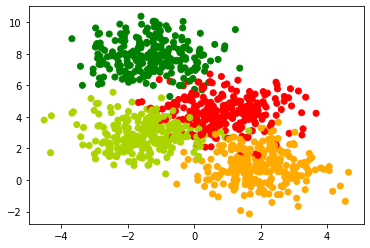

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

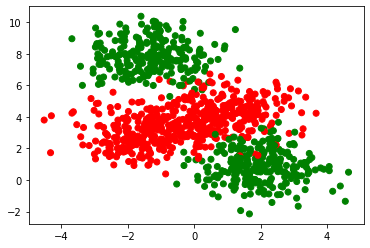

In [7]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Multi class classification

In [8]:
# Initialyy also computing the One hot encoded values
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [9]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [10]:
# Slightly vectorised notation, we are cleating 2 random matrices of teh sizes specified, 
# which are corresponding to the two layers
# seed is set to 0 which ensures everytime we get the same set of values
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


In [11]:
# There are some modifications that are done to support the different GD algo.
class FFNetwork:
  
  def __init__(self, W1, W2):
        
    self.params={}
    self.params["W1"]=W1.copy()
    self.params["W2"]=W2.copy()
    self.params["B1"]=np.zeros((1,2))
    self.params["B2"]=np.zeros((1,4))
    self.num_layers=2
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    # Just initialising some variables here to later code look simple
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  # sigmoid fucntion
  def forward_activation(self, X): 
    return 1.0/(1.0 + np.exp(-X))
  
  # gradient of a sigmoid function
  def grad_activation(self, X):
    return X*(1-X) 

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  # params = None, if we have parameters which are different fromt he class that out current class is modelling
  def forward_pass(self, X, params = None):
    # if params is not defined then we will take params self value
    if params is None:
        params = self.params
    # The next 4 lines impements the forward pass
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2) N here is the number of items in X
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
    
    # Calling forward pass first
    self.forward_pass(X, params)
    m = X.shape[0]
    # We are taking the gradient decent backwards, backpropagation
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  # Main changes are in the fit function -  It now has a series of if conditions for each possible setting of the GD Algos
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
      
    if display_loss:
      loss = {}
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      # Standard -  aggrigating the gradients, bu one vectorised notation, were dW contains all the gradients
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
      
      # For minibatch the difference from the regular GD is that we have divided X and Y into smaller peices of some size and then normalise
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
      
      # Momentum will need some additional parametes and we are calling them update params.
      # we are taking the exponetially weighted sum of gradients, gamma times the prev value and eta times whatever we would like to update
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
      
      # We have to first compute the gamma times the parametes and then 
      # computing some temp params and on that we apply the update rule
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    if display_loss:
      plt.plot(loss.values(), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [12]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

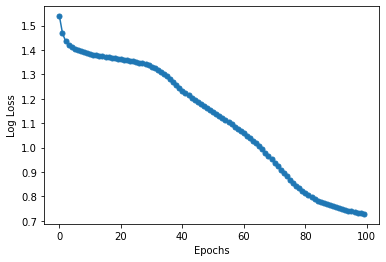

Training accuracy 0.7053
Validation accuracy 0.716
Wall time: 941 ms


In [13]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

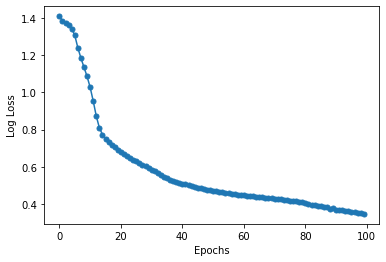

Training accuracy 0.8867
Validation accuracy 0.904
Wall time: 646 ms


In [14]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()
# We will see more updates being made and the data set as we know has 720 data points this takes 128 at a time and updates them, 
# as we can see a much higher accuracy than that of the regular GD algo. Time taken is roughly the same 

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

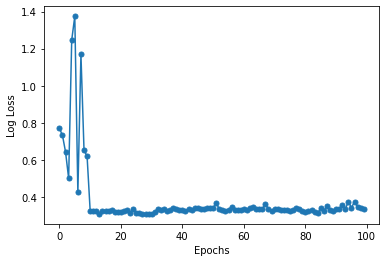

Training accuracy 0.8707
Validation accuracy 0.876
Wall time: 2.95 s


In [15]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()
# as we change the minibatch size to a smaller value, things are not working very well, things get noisy. 
# Just from one update to the other update there were huge swings in the loss, therefore we can conclude that this is a very small batch size.

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

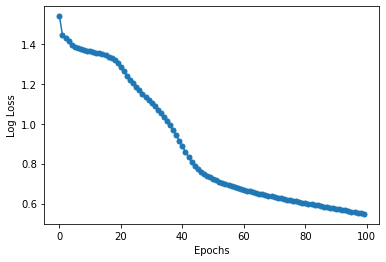

Training accuracy 0.8387
Validation accuracy 0.852
Wall time: 821 ms


In [16]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()


<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

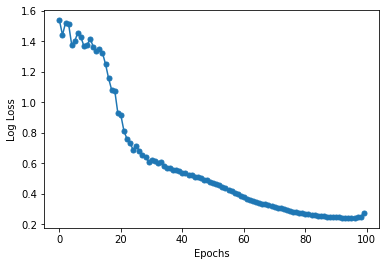

Training accuracy 0.8947
Validation accuracy 0.916
Wall time: 829 ms


In [17]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()
# If we increase the gamma here from 0.5 to a larger number say 0.9 then we can see ossilations as by increasing the momentum
# for such varies parameter sizes like 18 it must have complex error surfaces which in momentum would mean ossilatins, but the accuracy increases


<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

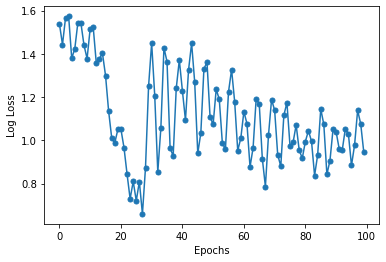

Training accuracy 0.6347
Validation accuracy 0.66
Wall time: 726 ms


In [18]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()
# If we try and increase the gamma even more in order to increase the accuracy then it builds momentms and goes in the wrong diresction, 
# and hence it is unable to see higher accuracy

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

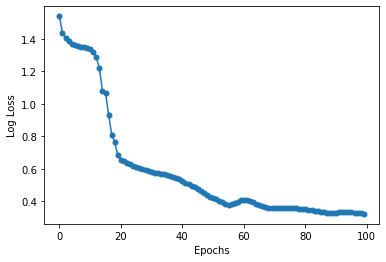

Training accuracy 0.88
Validation accuracy 0.872
Wall time: 1.43 s


In [19]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()
# We can see in NAG that even in gamma 0.99 which is a high momentum it is not ossilating
# The accuracy is decent but it is not the higest we have seen

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

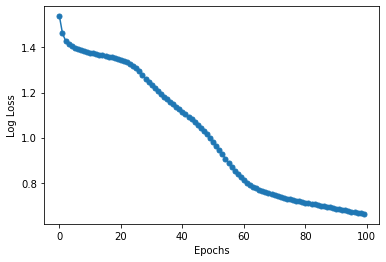

Training accuracy 0.704
Validation accuracy 0.728
Wall time: 710 ms


In [20]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()
# While we decrease the momenttum term gamma it decreases the accuracy but the sooilations are further decreased

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

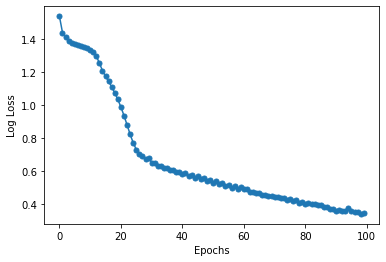

Training accuracy 0.8773
Validation accuracy 0.9
Wall time: 766 ms


In [21]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()
# If we take a appopriate gamma then the ossilations are less and the accuracy is high

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

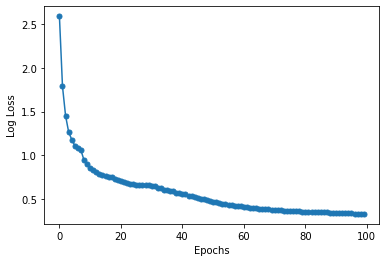

Training accuracy 0.88
Validation accuracy 0.904
Wall time: 551 ms


In [22]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()
# Adagrad starts of badyly initially, it is beacuse in the beggening it the parameter is zero or almost zero, 
# it only later starts to accumulate some value, so initially wehn divided by eps whichc is somewhere close to 1, 
# the values are not great. It has a very reasonale accuracy.


<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

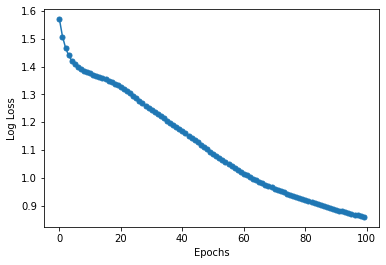

Training accuracy 0.644
Validation accuracy 0.636
Wall time: 519 ms


In [23]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()
# The problem was when eta is low or a very flat error surface then it performs very slow

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

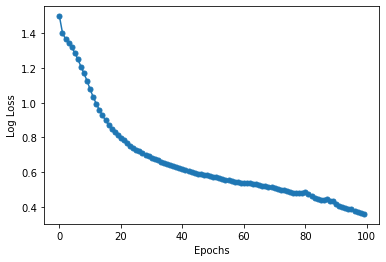

Training accuracy 0.8827
Validation accuracy 0.908
Wall time: 583 ms


In [24]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()
# RMSProp is able to do the same thing what Adagrad was doing with eta 1

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

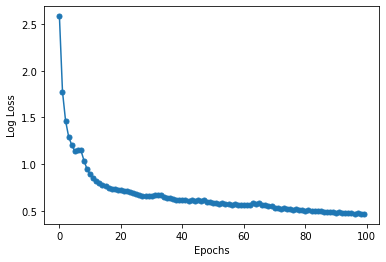

Training accuracy 0.844
Validation accuracy 0.876
Wall time: 761 ms


In [25]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.99, display_loss=True)
print_accuracy()
# If we further increase the learning arte eta then the accuracy starts to decrease as there are ossilations

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

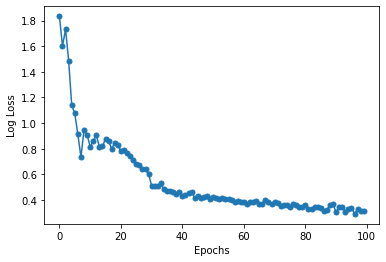

Training accuracy 0.8973
Validation accuracy 0.884
Wall time: 780 ms


In [26]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()
# Adam combines the best of both the worlds.
# for beta and eta of 0.9, it is haveing a resonable accuracy, but there are some ossilations.

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

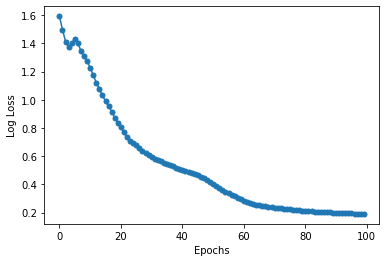

Training accuracy 0.9227
Validation accuracy 0.94
Wall time: 669 ms


In [27]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()
# We get the highest accuracy we have seen soo far. It is a bit slower as we are maintaing 2 seets of running sums
# and also doing some bias correction.

## Good configurations with each algo

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/10000 [00:00<?, ?epoch/s]

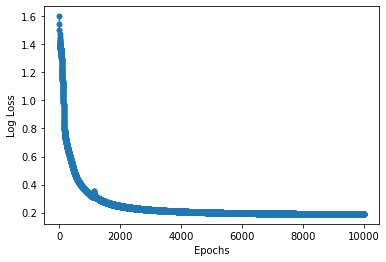

Training accuracy 0.924
Validation accuracy 0.928
Wall time: 24.5 s


In [28]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
print_accuracy()
# These configurations not the best configuration, finding the best configuration by itself is a process - Hyperparameter tuning
# In vanilla GD if we use a learning rate of 0.5 it does not have many ossilatoins, but then we have to run it for 10000 epochs
# If there are ossilations then the learning rate should be decreased.

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/1000 [00:00<?, ?epoch/s]

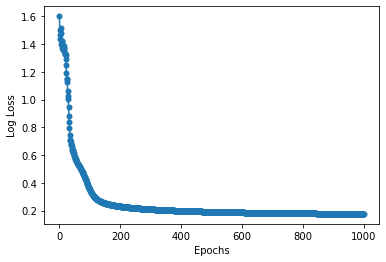

Training accuracy 0.9267
Validation accuracy 0.944
Wall time: 1.88 s


In [29]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()
# In Momentum it turns out that the gamma of 0.9 and eta of 0.5 within a 1000 epoch(which is 1/10 the number of epochs in vanilla GD)
# Sometimes the momentum does not work as we have a very large value for gamma, which shows up in the form of ossilations, 
# the responce to that could be to reduce the eta term or gamma term, trade of is not that clear it depends from prooblem to problem

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/1000 [00:00<?, ?epoch/s]

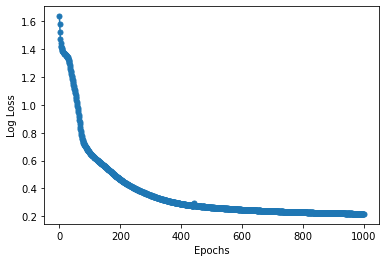

Training accuracy 0.9213
Validation accuracy 0.94
Wall time: 5.81 s


In [30]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()
# Now similarly inii NAG case gamma of 0.9 and eta of 0.5 with 1000 epochs gives us slightly more accuracy.
# If momentum is working well then there is not much improvemnt we can see in NAG.

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/500 [00:00<?, ?epoch/s]

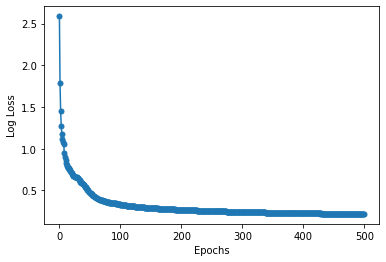

Training accuracy 0.912
Validation accuracy 0.936
Wall time: 2.18 s


In [31]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()
# with a eta of 1 within 500 epochs we are getting the very similar accuracy as that of momentum and NAG
# a bit more computation is done in adagrad so it takes a little longer to run

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

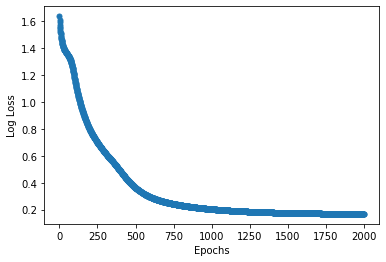

Training accuracy 0.9253
Validation accuracy 0.94
Wall time: 12.6 s


In [32]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()
# RMSProp can tolerate much more smaller learning rates which Adagrad cannot, here more number of epochs is a good choice.

<ipython-input-11-e141e2156d86>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/200 [00:00<?, ?epoch/s]

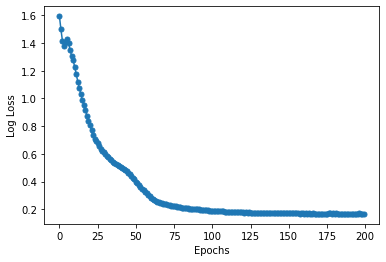

Training accuracy 0.9293
Validation accuracy 0.952
Wall time: 1.29 s


In [33]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()
# finally with Atom, which brings the best of both the worlds, we can give an eta of .1 and very less epochs and have a better accuracy

## Exercise

0. Duplicate this exercise for our smaller network with 3 neurons (binary classification). In this case, you can practise writing the vectorised form of the gradient descent. 

1. After training for a few epochs, freeze updates to all variables, except two (say w_1 and w_2 in our diagram). Now we have a situation similar to the previous setting (where there are two variables and we can plot 2d and 3d plots). Plot the error surface and animate to visualise each algorithm. 

2. Try 1. with different parameters (say w_3, b_2) and observe how the algorithms work
